# AIMS CDT Data, Estimation and Inference Lab

# Preliminary Data Investigation & Loading

In [2]:
# import packages
using CSV;
using Plots;
using Dates, Statistics, Printf, LinearAlgebra, Distributions;
pyplot()

Let's look at the cells. 

In [3]:
data = CSV.read("data.csv")
data=data[1:end-1, :]

1256×19 DataFrames.DataFrame. Omitted printing of 17 columns
│ Row  │ Update Date and Time (ISO) │ Update Duration (ms) │
│      │ DateTime                   │ Int64                │
├──────┼────────────────────────────┼──────────────────────┤
│ 1    │ 2007-05-26T12:05:00        │ 0                    │
│ 2    │ 2007-05-26T12:10:00        │ 0                    │
│ 3    │ 2007-05-26T12:15:00        │ 0                    │
│ 4    │ 2007-05-26T12:20:00        │ 0                    │
│ 5    │ 2007-05-26T12:25:00        │ 0                    │
│ 6    │ 2007-05-26T12:30:00        │ 0                    │
│ 7    │ 2007-05-26T12:35:00        │ 0                    │
│ 8    │ 2007-05-26T12:40:00        │ 0                    │
│ 9    │ 2007-05-26T12:45:00        │ 0                    │
│ 10   │ 2007-05-26T12:50:00        │ 0                    │
⋮
│ 1246 │ 2007-05-31T15:20:00        │ 0                    │
│ 1247 │ 2007-05-31T15:25:00        │ 0                    │
│ 1248 │ 2007-05-31T15:30:00        │ 0                    │
│ 1249 │ 2007-05-31T15:35:00        │ 0                    │
│ 1250 │ 2007-05-31T15:40:00        │ 0                    │
│ 1251 │ 2007-05-31T15:45:00        │ 0                    │
│ 1252 │ 2007-05-31T15:50:00        │ 0                    │
│ 1253 │ 2007-05-31T15:55:00        │ 0                    │
│ 1254 │ 2007-05-31T16:00:00        │ 0                    │
│ 1255 │ 2007-05-31T16:05:00        │ 0                    │
│ 1256 │ 2007-05-31T16:10:00        │ 0                    │

In [4]:
data[1, :]

DataFrameRow. Omitted printing of 17 columns
│ Row │ Update Date and Time (ISO) │ Update Duration (ms) │
│     │ DateTime                   │ Int64                │
├─────┼────────────────────────────┼──────────────────────┤
│ 1   │ 2007-05-26T12:05:00        │ 0                    │

In [5]:
data[1256, :]

DataFrameRow. Omitted printing of 17 columns
│ Row  │ Update Date and Time (ISO) │ Update Duration (ms) │
│      │ DateTime                   │ Int64                │
├──────┼────────────────────────────┼──────────────────────┤
│ 1256 │ 2007-05-31T16:10:00        │ 0                    │

Note that the data is taken across a number of different days, spaced (primarily) at different times. This might mean that we should use a periodic covariance function.

In [6]:
# looks like reading time is column 3, tide height reading is column 6
names(data)

19-element Array{Symbol,1}:
 Symbol("Update Date and Time (ISO)")                
 Symbol("Update Duration (ms)")                      
 Symbol("Reading Date and Time (ISO)")               
 Symbol("Air pressure (mb)")                         
 Symbol("Air temperature (C)")                       
 Symbol("Tide height (m)")                           
 Symbol("Wind direction (deg)")                      
 Symbol("Wind gust speed (kn)")                      
 Symbol("Wind speed (kn)")                           
 Symbol("True air temperature (C)")                  
 Symbol("True tide height (m)")                      
 Symbol("Independent tide height prediction (m)")    
 Symbol("Independent tide height deviation (m)")     
 Symbol("Dependent tide height prediction (m)")      
 Symbol("Dependent tide height deviation (m)")       
 Symbol("Independent air temperature prediction (C)")
 Symbol("Independent air temperature deviation (C)") 
 Symbol("Dependent air temperature prediction (C)")  


In [7]:
t = data[:, 3]

1256-element Array{DateTime,1}:
 2007-05-26T12:05:00
 2007-05-26T12:10:00
 2007-05-26T12:15:00
 2007-05-26T12:20:00
 2007-05-26T12:25:00
 2007-05-26T12:30:00
 2007-05-26T12:35:00
 2007-05-26T12:40:00
 2007-05-26T12:45:00
 2007-05-26T12:50:00
 2007-05-26T12:55:00
 2007-05-26T13:00:00
 2007-05-26T13:05:00
 ⋮                  
 2007-05-31T15:15:00
 2007-05-31T15:20:00
 2007-05-31T15:25:00
 2007-05-31T15:30:00
 2007-05-31T15:35:00
 2007-05-31T15:40:00
 2007-05-31T15:45:00
 2007-05-31T15:50:00
 2007-05-31T15:55:00
 2007-05-31T16:00:00
 2007-05-31T16:05:00
 2007-05-31T16:10:00

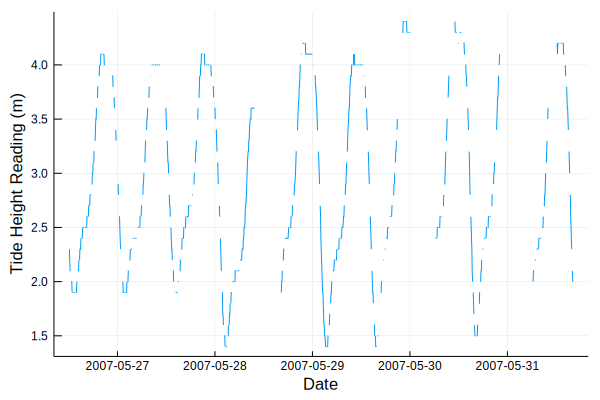

In [8]:
# Let's look at the data! as a function simply of the index
plot(data[:, 3], data[:, 6], xlabel="Date", ylabel="Tide Height Reading (m)", label="")

Comments:

1. The data looks periodic. 

2. The mean value is approximately 3

Lets calculate the mean and standard deviation, skipping the missing values. This will be useful for initial hyperparameter settings. 

In [9]:
@printf("Mean: %.3f\nStd : %.3f", Statistics.mean(skipmissing(data[:, 6])), Statistics.std(skipmissing(data[:, 6])))

Mean: 2.938
Std : 0.846

# Initial Gaussian Process Investigations

First, let's put the data into a slight more convenient format. In particular, let's reformat the input date string. 

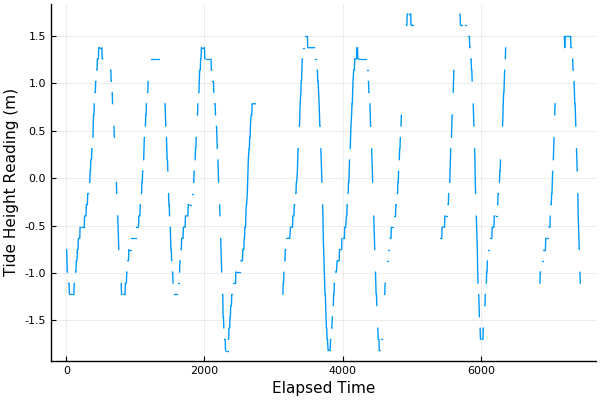

In [201]:
# it would be nicer to stick with the julia Datetime format, but we need numbers, so instead, let us
# get the seconds from the epoch, and then convert into minutes ...
t = (map(Dates.datetime2unix, data[:, 3]) .- Dates.datetime2unix(data[1, 3]))/60
y_offset = Statistics.mean(skipmissing(data[:, 6]))
y_scale = Statistics.std(skipmissing(data[:, 6]))

y = (data[:, 6] .- y_offset) ./ y_scale
missing_indices = map(ismissing, y);

ground_truth = (data[:, 11] .- y_offset) ./y_scale;

t_pred = reshape(t[missing_indices], length(t[missing_indices]), 1)
y_pred = ground_truth[missing_indices]
t_all = reshape(t, length(t), 1)

t_train = reshape(t[map(~, missing_indices)] , length(t[map(~, missing_indices)]),  1)
y_train = y[map(~, missing_indices)]
gt_train = ground_truth[map(~, missing_indices)]

plot(t, y, xlabel="Elapsed Time", ylabel="Tide Height Reading (m)", label="")

In [11]:
t_train

916×1 Array{Float64,2}:
    5.0
   10.0
   15.0
   20.0
   30.0
   35.0
   40.0
   45.0
   55.0
   60.0
   65.0
   70.0
   80.0
    ⋮  
 7370.0
 7375.0
 7385.0
 7390.0
 7395.0
 7405.0
 7410.0
 7415.0
 7420.0
 7425.0
 7435.0
 7440.0

Choosing a mean and covariance function. As suggested, let's try the RBF kernel, setting the width to be approximately 60 minutes and scale value to be approximately the standard deviation. 

The noise seems to be pretty small looking above. 

In [12]:
κ(x₁, x₂) = 0.85^2 * exp(-(LinearAlgebra.norm(x₁ - x₂)^2) / (60));
# \sigma_n represents the model noise
σₙ = 0.25;

In [13]:
function compute_K(x, κ)
    n = size(x)[1]
    K = Array{Float64}(undef, n,n)
    # lazy, for lo32
    for i in 1:n
        for j in 1:n
            if i>=j
                K[i, j] = κ(x[i], x[j])
                K[j, i] = K[i, j]
            end
        end
    end
    K = K + 1e-10 * I
#     print(eigvals(K))
#     println(isposdef(K))
#     println(LinearAlgebra.transpose(K) == K)
    return K
    end;


# x is the matrix of training data points
# x_hat is the predictive points matrix
function compute_k(x̂, x, κ)
    N, d = size(x)
    n, d = size(x̂)
    # k should be a N x n matrix (as the rest is N x 1)
    k = Array{Float32}(undef, N, n)
    for i in 1:N
        for j in 1:n
            k[i, j] = κ(x[i], x̂[j])
        end
    end
    return k
    end;


function compute_predictive_distribution(x̂, X, y, κ, σₙ, σⱼ=0)
    
    if length(X) > 0
        # compute common quantities
        K_train = Hermitian(compute_K(X, κ));
        k_pred_train = compute_k(x̂, X, κ);
        k_pred = Hermitian(compute_K(x̂, κ));

        # compute difficult matrix inverse
        mat_inv = Symmetric(LinearAlgebra.inv(K_train + (σₙ^2+σⱼ^2) * I));

        mean = LinearAlgebra.transpose(k_pred_train) * mat_inv * y;
        f_cov = Symmetric((k_pred) - LinearAlgebra.transpose(k_pred_train) * mat_inv * k_pred_train); 
        cov = f_cov + (σₙ^2 * I)

        mean = Array{Float64}(mean)
    else
        k_pred = Hermitian(compute_K(x̂, κ));
        N, d = size(x̂);
        f_cov = Symmetric(k_pred)
        cov = f_cov + (σₙ^2 * I)
        mean = zeros(N)
    end
        
    return mean, diag(cov), Symmetric(cov), Symmetric(f_cov)
    end;

# compute predictivity log likelihood.
function performance_evaluation(ground_truth, means, func_cov, test_indices)
    RMS_error = mean((ground_truth .- means).^2)^0.5
    HO_RMS_error = mean((ground_truth[test_indices] .- means[test_indices]).^2)^0.5
    test_cov = Array(Symmetric(func_cov[test_indices, test_indices]))
    test_cov = diag(test_cov)
    test_mean = means[test_indices]
    
    test_dist = Distributions.MvNormal(test_mean, (test_cov).^0.5)
    pred_likelihood = Distributions.logpdf(test_dist, ground_truth[test_indices])/sum(test_indices)

    @printf("RMS: %.3f\nHeld Out RMS: %.3f\nPredictive Average Log Likelihood: %.3f", RMS_error, HO_RMS_error, pred_likelihood)
    return RMS_error, HO_RMS_error, pred_likelihood
    end;

function gen_sqexp_cov_func(log_length_scale, scale)
    κ(x₁, x₂) = scale^2 * exp(-(LinearAlgebra.norm(x₁ - x₂)^2) / (2 * (exp(log_length_scale))^2));
    return κ;
    end;

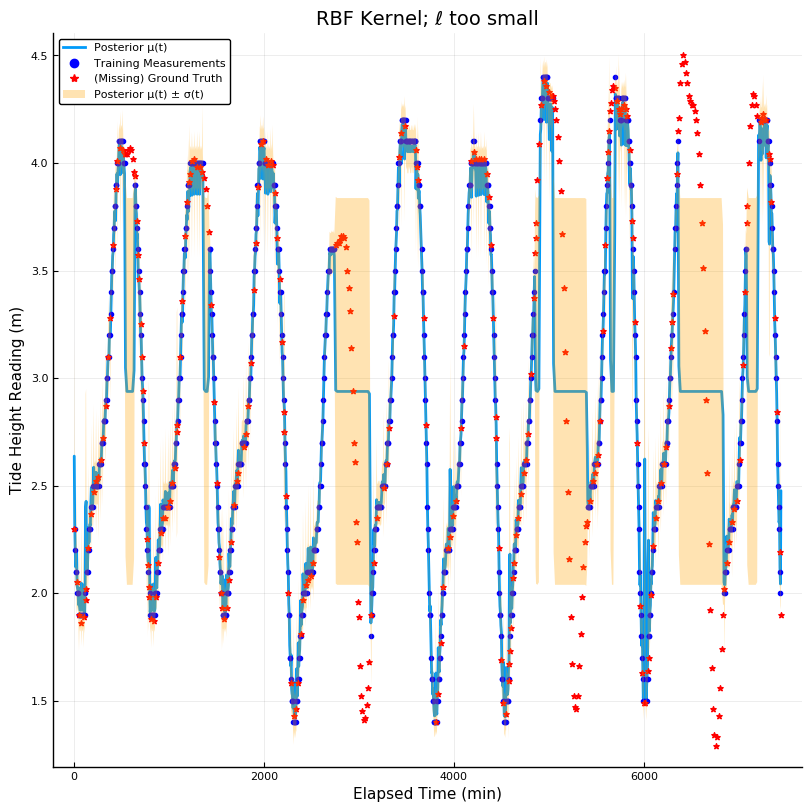

RMS: 0.399
Held Out RMS: 0.763
Predictive Average Log Likelihood: -0.848

In [206]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_sqexp_cov_func(log(5), 1), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset
σs = σs .* y_scale;

p1 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="Posterior μ(t)", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="Training Measurements", title="RBF Kernel; ℓ too small")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="(Missing) Ground Truth")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="Posterior μ(t) ± σ(t)");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
savefig("badkernel1.pdf")

RMS: 0.242
Held Out RMS: 0.464
Predictive Average Log Likelihood: 0.724

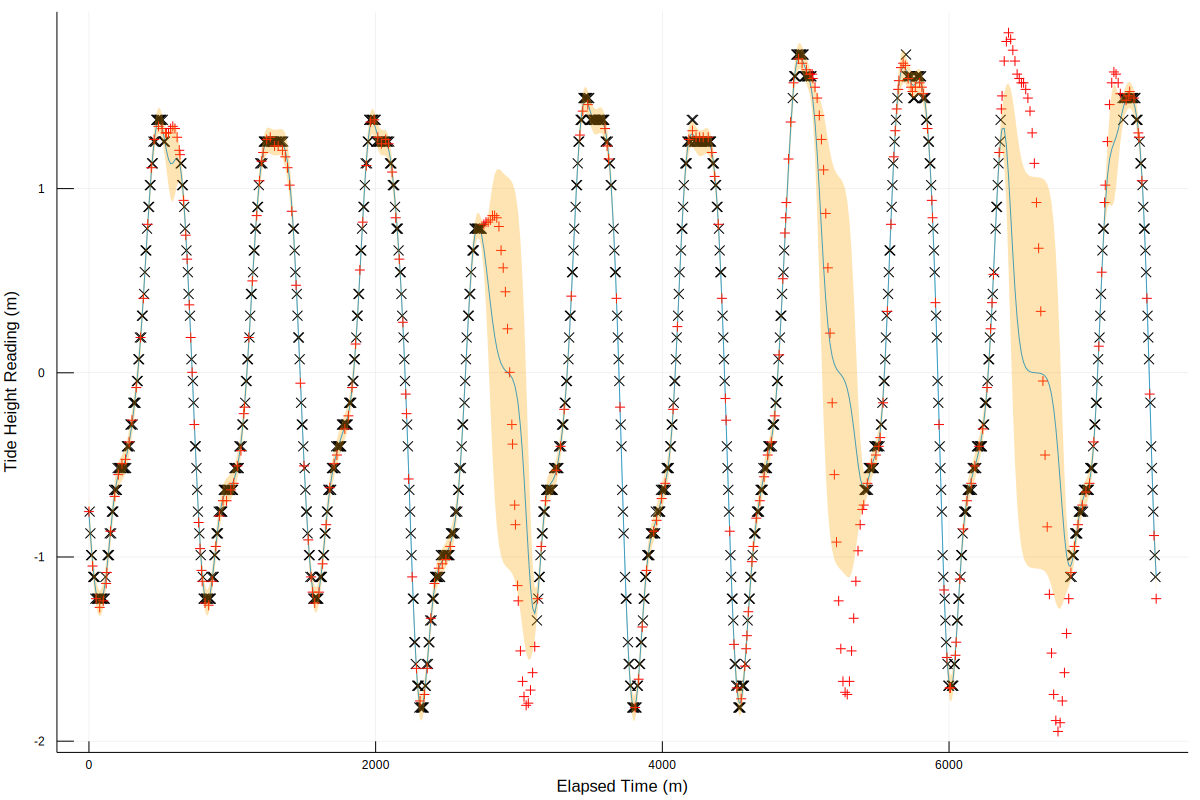

In [15]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_sqexp_cov_func(log(60), 1), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
plot(t, means, xlabel="Elapsed Time (m)", ylabel="Tide Height Reading (m)", label="", show=true, size=(1200, 800))
plot!(t_train, y_train, seriestype=:scatter, label="", markershape=:x)
scatter!(t_pred, y_pred, seriestype=:scatter, label="", markershape=:+, markerstrokecolor=markercolor=:red)
plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, label="", linewidth=0, show=true)

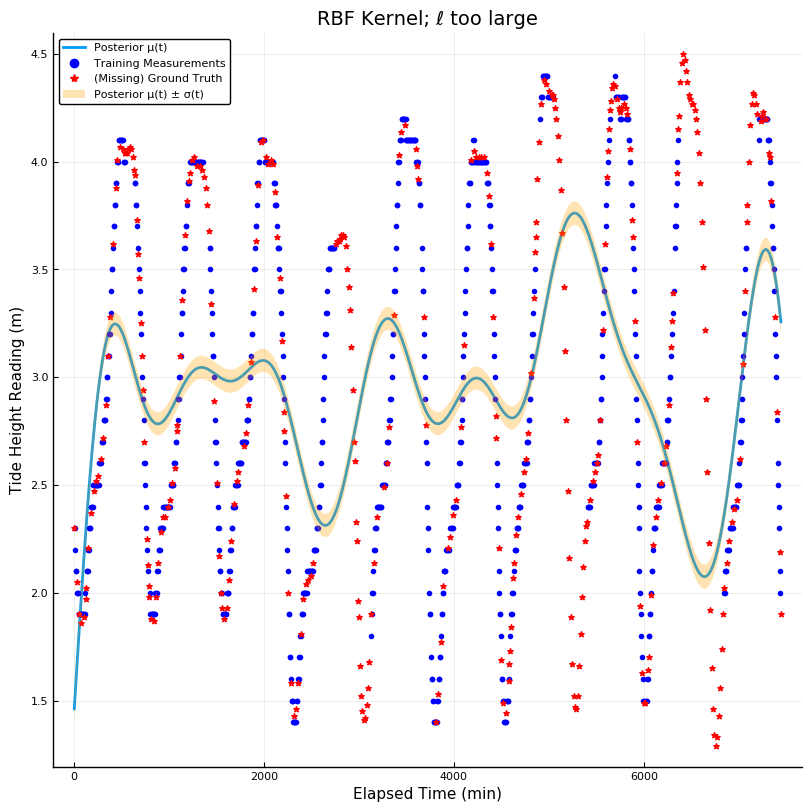

RMS: 0.971
Held Out RMS: 1.150
Predictive Average Log Likelihood: -405.633

In [205]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_sqexp_cov_func(log(600), 1), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;
σs = σs .* y_scale;

p1 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="Posterior μ(t)", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="Training Measurements", title="RBF Kernel; ℓ too large")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="(Missing) Ground Truth")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="Posterior μ(t) ± σ(t)");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
savefig("badkernel2.pdf")

Lets try and optimise the hyperparameters of our kernel function instead. 

# RBF Kernel

In [17]:
using Optim

function RBF_likelihood(x)
    cov_func = gen_sqexp_cov_func(x[1], exp(x[2]))
    K = compute_K(t_train, cov_func);
    K = K + σₙ^2 * I;
    L = -LinearAlgebra.transpose(y_train) * LinearAlgebra.inv(K) * y_train - (LinearAlgebra.logdet(K))
    return -L
    end;

function f(x)
    return (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
    end;

In [18]:
Optim.optimize(RBF_likelihood, [log(60) 1.0], BFGS())

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.68e+00, 7.88e-02]
    Minimum:   -2.121008e+03

 * Found with
    Algorithm:     BFGS
    Initial Point: [4.09e+00, 1.00e+00]

 * Convergence measures
    |x - x'|               = 1.82e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.88e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.09e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e-16 ≰ 0.0e+00
    |g(x)|                 = 3.00e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    10
    f(x) calls:    43
    ∇f(x) calls:   43


In [77]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_sqexp_cov_func(4.55, 1.35), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;

RMS: 0.172
Held Out RMS: 0.328
Predictive Average Log Likelihood: 0.929

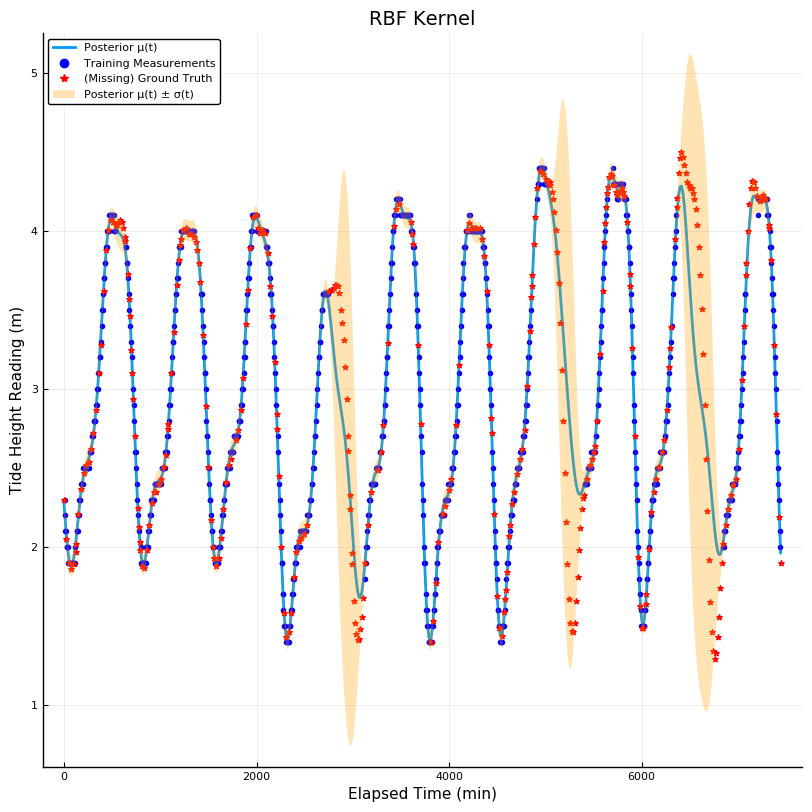

In [78]:
p1 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="Posterior μ(t)", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="Training Measurements", title="RBF Kernel")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="(Missing) Ground Truth")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="Posterior μ(t) ± σ(t)");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");

In [71]:
function gen_periodic_kernel(σ̂, l̂, p̂)
    κ(x₁, x₂) = exp(2*σ̂) * exp(- ( sin(π * LinearAlgebra.norm(x₁ - x₂) / exp(p̂)) ^2) * 2 * (exp(-2*l̂)))
    return κ
    end;
        
        
function Periodic_likelihood(x)
#     println(x)
    cov_func = gen_periodic_kernel(x[1], x[2], x[3])
    K = compute_K(t_train, cov_func);
    K = K + σₙ^2 * I;
    L = -LinearAlgebra.transpose(y_train) * LinearAlgebra.inv(K) * y_train -  (LinearAlgebra.logdet(K))
    return -L
    end;

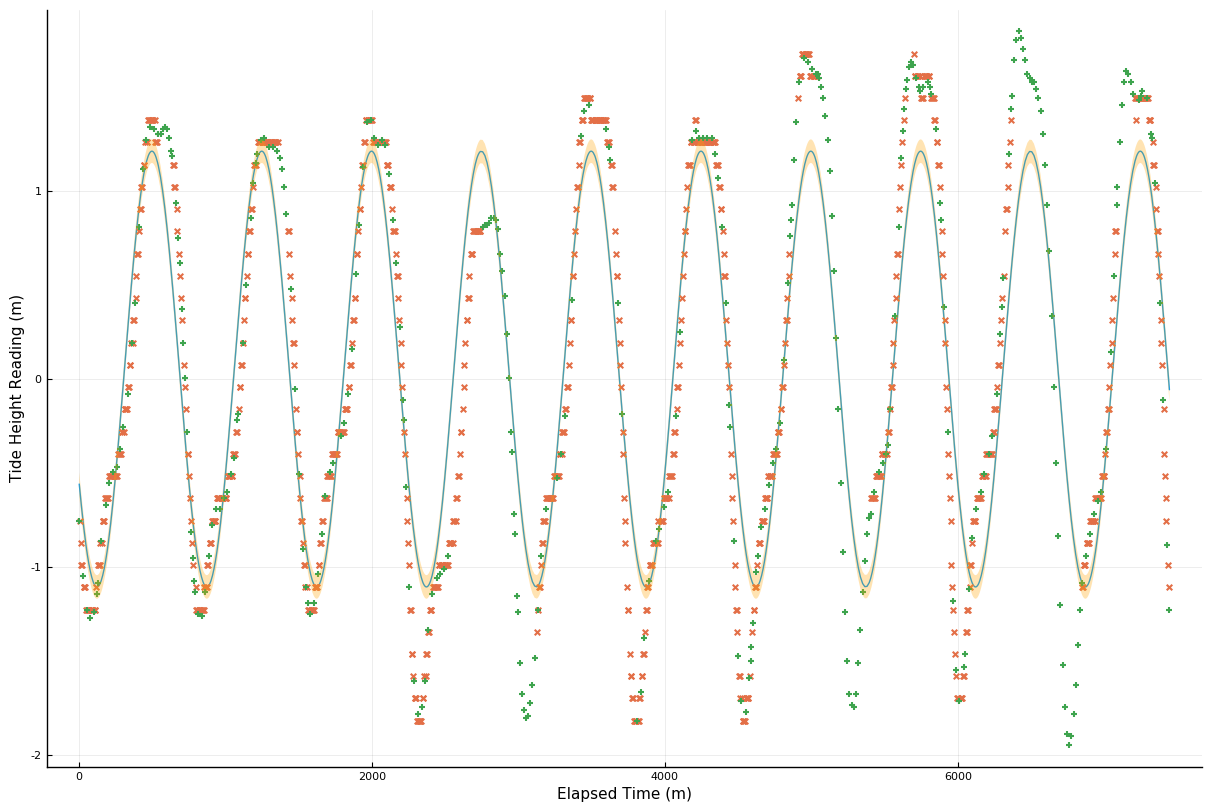

RMS: 0.416
Held Out RMS: 0.482
Predictive Average Log Likelihood: -567.870

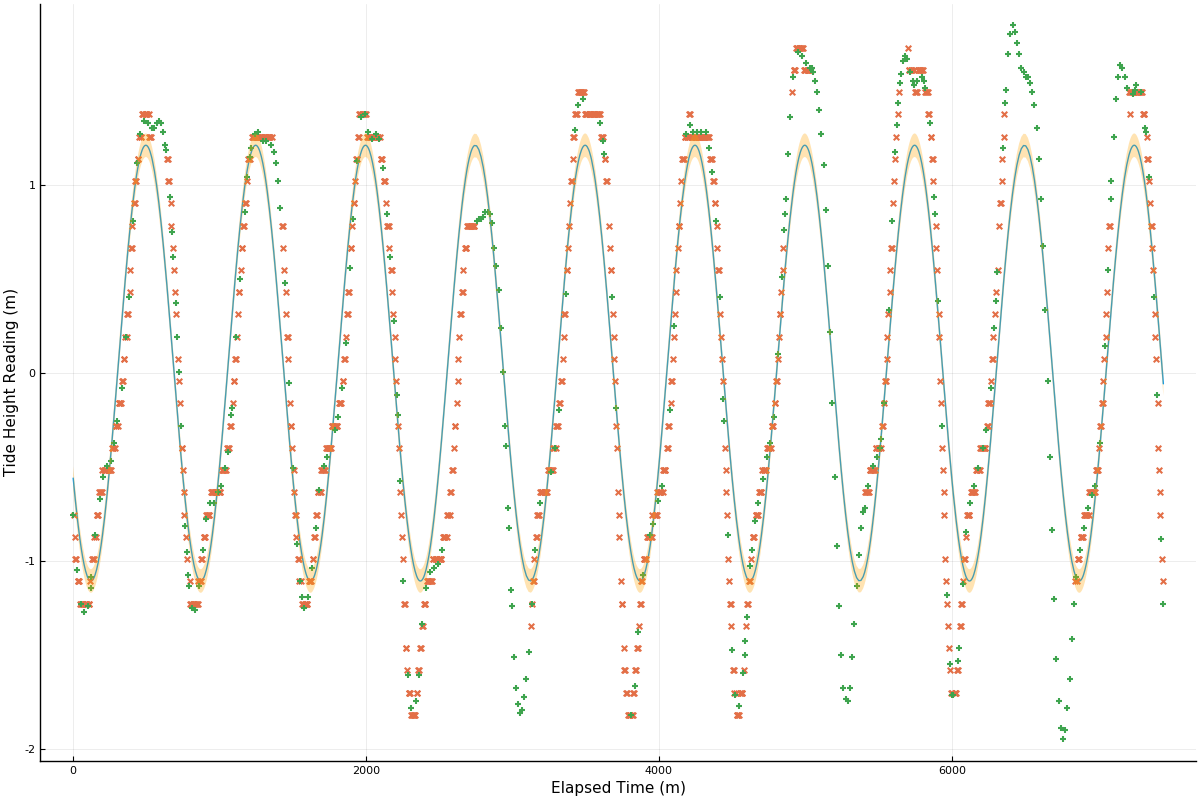

In [72]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_periodic_kernel(log(2), log(60), log(750)), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
plot(t, means, xlabel="Elapsed Time (m)", ylabel="Tide Height Reading (m)", label="", show=true, size=(1200, 800))
plot!(t_train, y_train, seriestype=:scatter, label="", markershape=:x)
scatter!(t_pred, y_pred, seriestype=:scatter, label="", markershape=:+, markerstrokecolor=markercolor=:red)
plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, label="", linewidth=0, show=true)

This looks somewhat close, but probably not quite right. Let's try optimising this.

In [73]:
Optim.optimize(Periodic_likelihood, [log(2), log(60), log(750)], Newton())

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.08e-01, 1.23e-01, 6.61e+00]
    Minimum:   -1.866844e+03

 * Found with
    Algorithm:     Newton's Method
    Initial Point: [6.93e-01, 4.09e+00, 6.62e+00]

 * Convergence measures
    |x - x'|               = 5.00e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.43e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.30e-14 ≰ 0.0e+00
    |g(x)|                 = 3.65e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   32  (vs limit Inf)
    Iterations:    12
    f(x) calls:    31
    ∇f(x) calls:   31
    ∇²f(x) calls:  13


In [82]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_periodic_kernel(0.21, 1.23e-1, 6.61), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;

RMS: 0.210
Held Out RMS: 0.232
Predictive Average Log Likelihood: -35.308

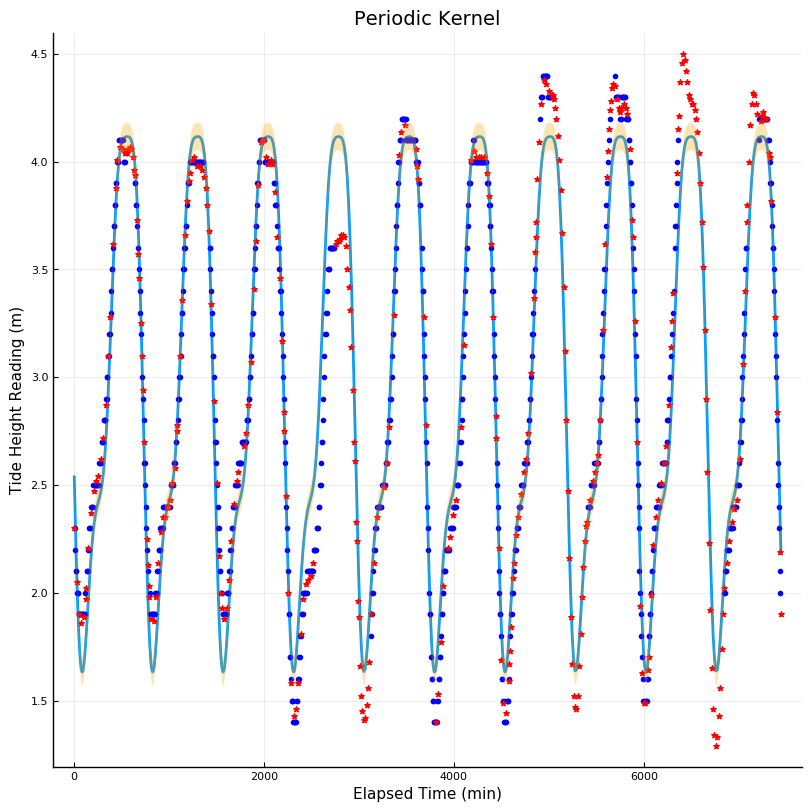

In [83]:
p2 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="", title="Periodic Kernel")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");

In [85]:
function gen_local_periodic_kernel(σ̂, l̂₁, p̂, l̂₂)
    κ(x₁, x₂) = exp(2*σ̂) * exp(- ( sin(π * LinearAlgebra.norm(x₁ - x₂) / exp(p̂)) ^2) * 2 * (exp(-2*l̂₁))) * exp(-LinearAlgebra.norm(x₁ - x₂)^2 * exp(-2*l̂₂)/2) 
    return κ
    end;
        
        
function Periodic_local_likelihood(x)
#     println(x)
    cov_func = gen_local_periodic_kernel(x[1], x[2], x[3], x[4])
    K = compute_K(t_train, cov_func);
    K = K + σₙ^2 * I;
    L = -LinearAlgebra.transpose(y_train) * LinearAlgebra.inv(K) * y_train -  (LinearAlgebra.logdet(K))
    return -L
    end;

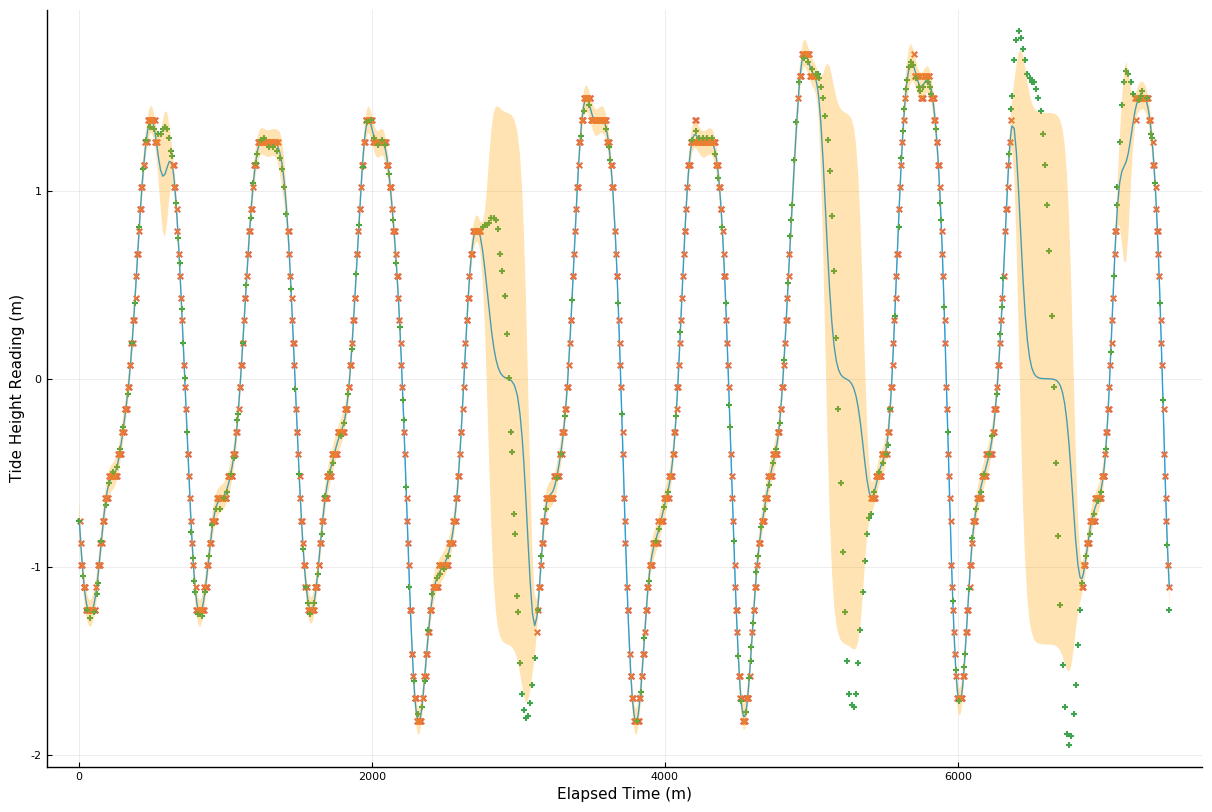

RMS: 0.253
Held Out RMS: 0.485
Predictive Average Log Likelihood: 0.655

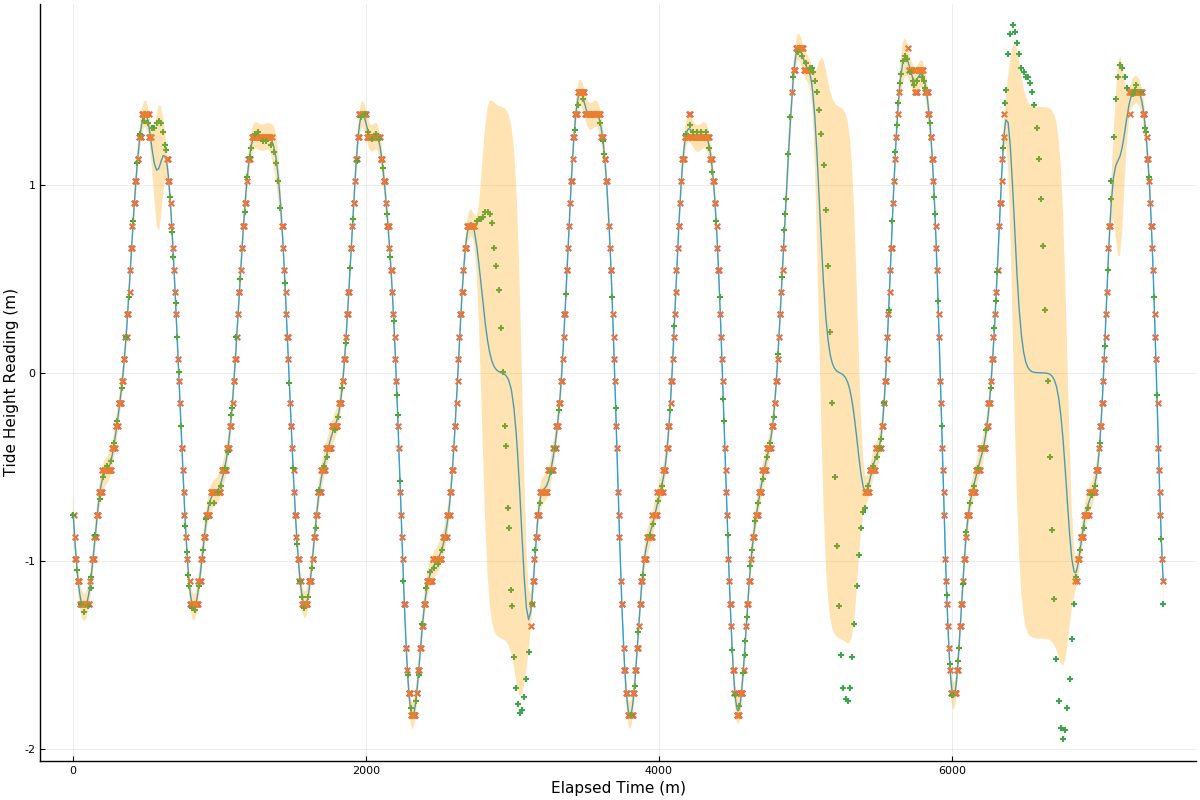

In [86]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_local_periodic_kernel(0.15, 3.46e-2, 6.61, log(60)), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
plot(t, means, xlabel="Elapsed Time (m)", ylabel="Tide Height Reading (m)", label="", show=true, size=(1200, 800))
plot!(t_train, y_train, seriestype=:scatter, label="", markershape=:x)
scatter!(t_pred, y_pred, seriestype=:scatter, label="", markershape=:+, markerstrokecolor=markercolor=:red)
plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, label="", linewidth=0, show=true)

In [87]:
Optim.optimize(Periodic_local_likelihood, [log(2), log(60), log(750), log(60)], LBFGS())

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [7.88e-02, 6.09e+00, 1.11e+01,  ...]
    Minimum:   -2.121008e+03

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [6.93e-01, 4.09e+00, 6.62e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.38e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.10e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.91e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.00e-15 ≰ 0.0e+00
    |g(x)|                 = 7.86e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   85  (vs limit Inf)
    Iterations:    15
    f(x) calls:    65
    ∇f(x) calls:   65


In [88]:
ans.minimizer

4-element Array{Float64,1}:
  0.07883967665584227
  6.089018900716372  
 11.06632767572375   
  4.683758013747205  

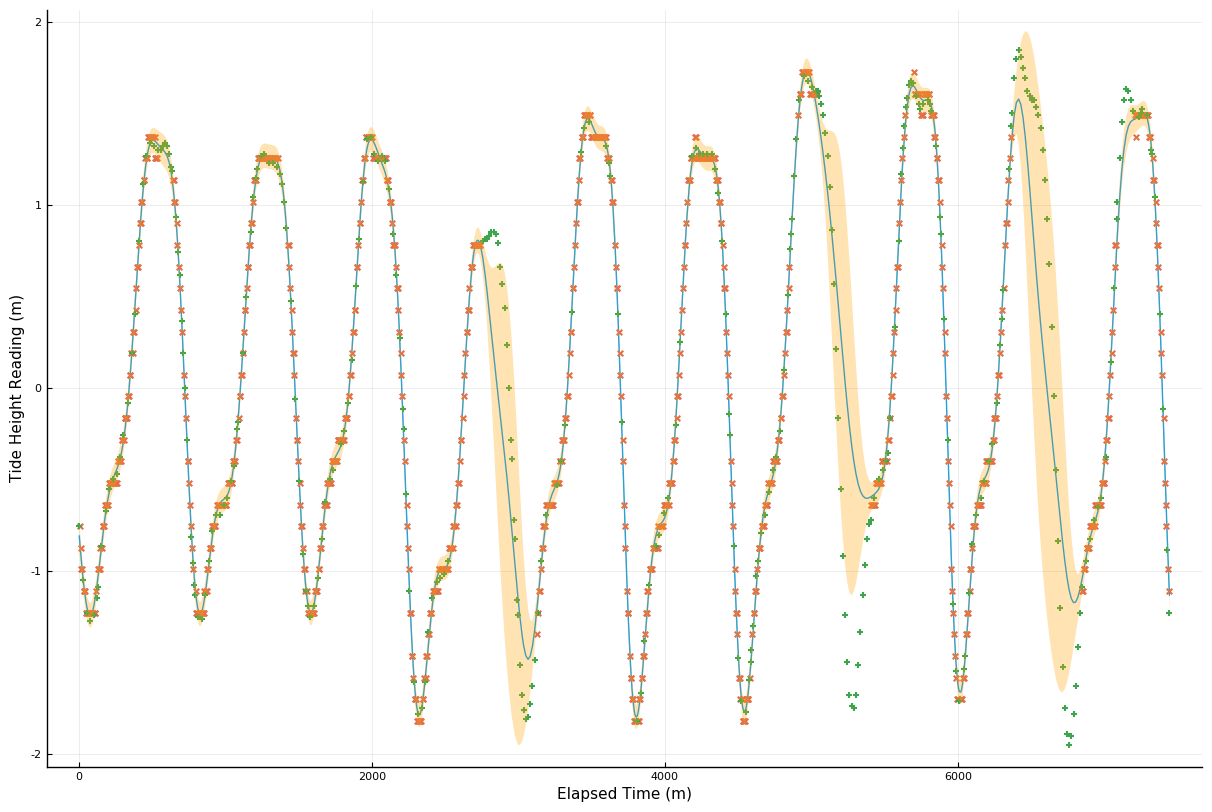

RMS: 0.171
Held Out RMS: 0.324
Predictive Average Log Likelihood: 0.948

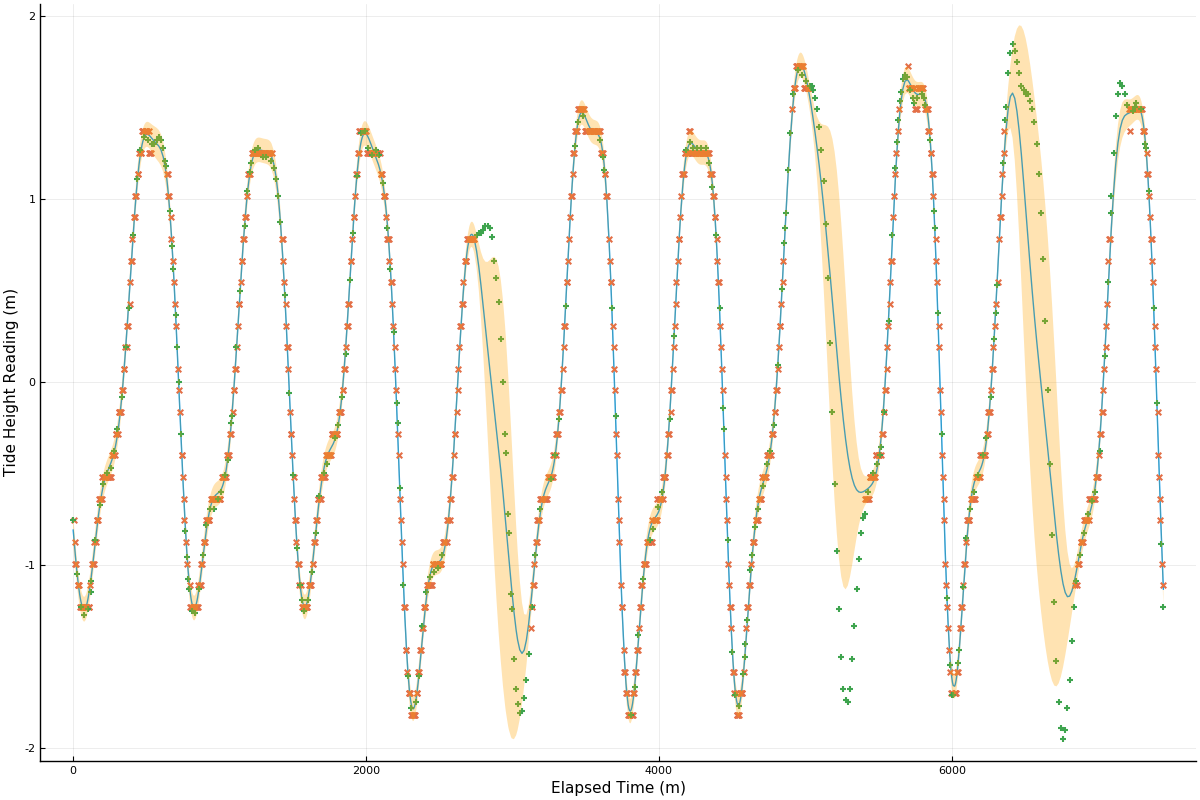

In [90]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_local_periodic_kernel(0.1, 3.41, 5.35, 4.68), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
plot(t, means, xlabel="Elapsed Time (m)", ylabel="Tide Height Reading (m)", label="", show=true, size=(1200, 800))
plot!(t_train, y_train, seriestype=:scatter, label="", markershape=:x)
scatter!(t_pred, y_pred, seriestype=:scatter, label="", markershape=:+, markerstrokecolor=markercolor=:red)
plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, label="", linewidth=0, show=true)

In [199]:
σₙ

0.25

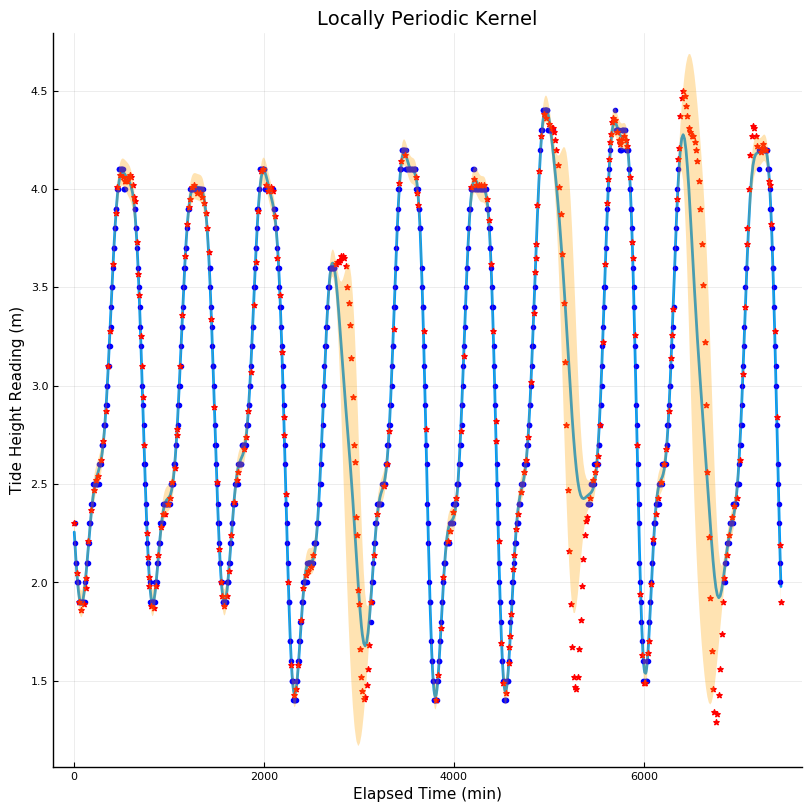

RMS: 0.170
Held Out RMS: 0.321
Predictive Average Log Likelihood: 0.954

In [96]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_local_periodic_kernel(0.097, 5.52, 9.5, 4.68), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset

p3 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="", title="Locally Periodic Kernel")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");

In [98]:
function gen_local_sum_periodic_kernel(σ̂, l̂, p̂, σ̂₂, l̂₂)
    κ(x₁, x₂) = exp(2*σ̂) * (exp(- ( sin(π * LinearAlgebra.norm(x₁ - x₂) / exp(p̂)) ^2) * 2 * (exp(-2*l̂)))) + exp(2*σ̂₂) * exp(-LinearAlgebra.norm(x₁ - x₂)^2 * exp(-2*l̂₂)/2) 
    return κ
    end;
        
        
function Periodic_local_sum_likelihood(x)
#     println(x)
    cov_func = gen_local_sum_periodic_kernel(x[1], x[2], x[3], x[4], x[5])
    K = compute_K(t_train, cov_func);
    K = K + σₙ^2 * I;
    L = -LinearAlgebra.transpose(y_train) * LinearAlgebra.inv(K) * y_train -  (LinearAlgebra.logdet(K))
    return -L
    end;

In [86]:
Optim.optimize(Periodic_local_sum_likelihood, [log(50), log(300),  log(750), log(0.5), log(90)], Newton())

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.55e-01, 1.23e-01, 6.61e+00,  ...]
    Minimum:   -2.290906e+03

 * Found with
    Algorithm:     Newton's Method
    Initial Point: [3.91e+00, 5.70e+00, 6.62e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.01e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.04e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.64e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.77e-15 ≰ 0.0e+00
    |g(x)|                 = 4.02e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   76  (vs limit Inf)
    Iterations:    9
    f(x) calls:    32
    ∇f(x) calls:   32
    ∇²f(x) calls:  10


In [87]:
ans.minimizer

5-element Array{Float64,1}:
  0.2550800590390298 
  0.12328545246715887
  6.6095026150543355 
 -1.5176562122022683 
  5.304680275077039  

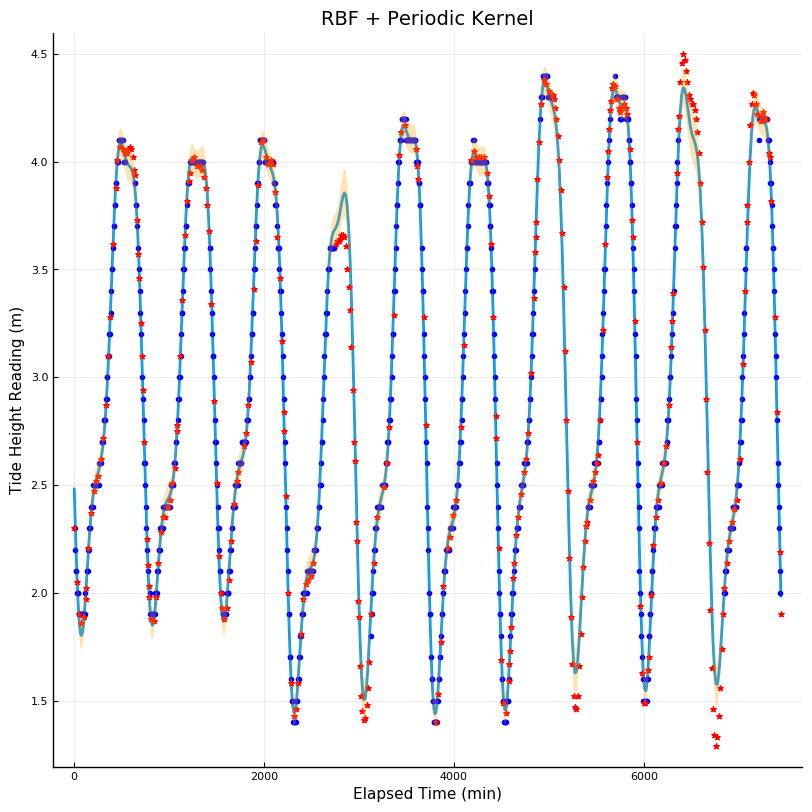

RMS: 0.059
Held Out RMS: 0.097
Predictive Average Log Likelihood: 1.279

In [114]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_local_sum_periodic_kernel(0.148, 0.06,  6.61, -1.48, 4.53), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset

p4 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="", title="RBF + Periodic Kernel")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");

This looks very good. Let's fix this covariance functon, and now look at sequential predictions.

# Summary plot. 

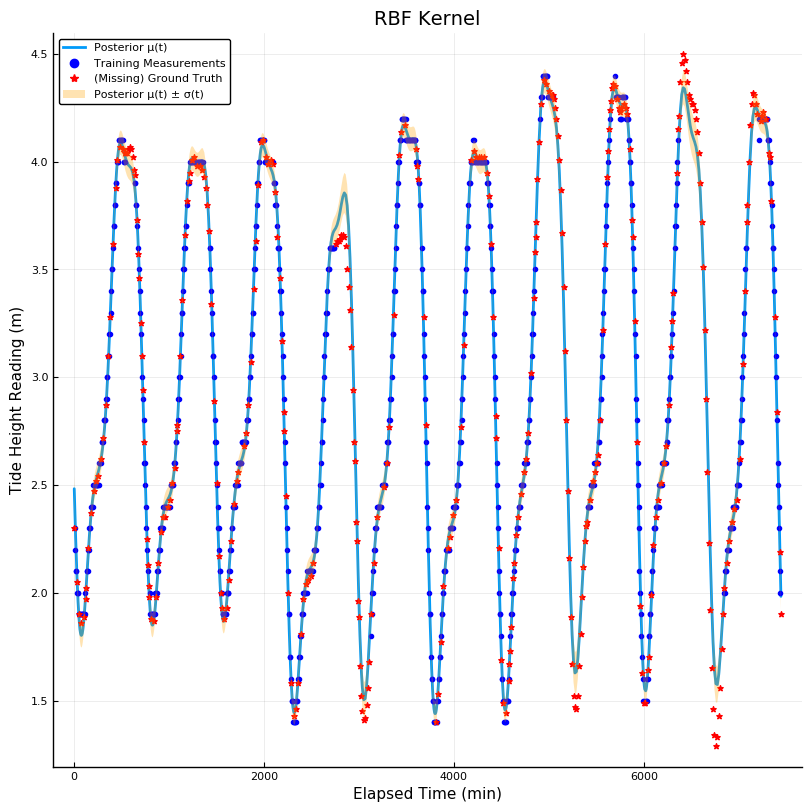

RMS: 0.059
Held Out RMS: 0.097
Predictive Average Log Likelihood: 1.279

In [179]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_local_sum_periodic_kernel(0.148, 0.06,  6.61, -1.48, 4.53), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;
σs = σs .* (y_scale);

p4 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="Posterior μ(t)", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="Training Measurements", title="RBF Kernel")
scatter!(t_pred, y_pred .* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="(Missing) Ground Truth")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="Posterior μ(t) ± σ(t)");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
savefig("best.pdf")

RBF
RMS: 0.175
Held Out RMS: 0.335
Predictive Average Log Likelihood: 1.473Periodic
RMS: 0.210
Held Out RMS: 0.231
Predictive Average Log Likelihood: -204.096Locally Periodic
RMS: 0.171
Held Out RMS: 0.326
Predictive Average Log Likelihood: 1.392Periodic + RBF


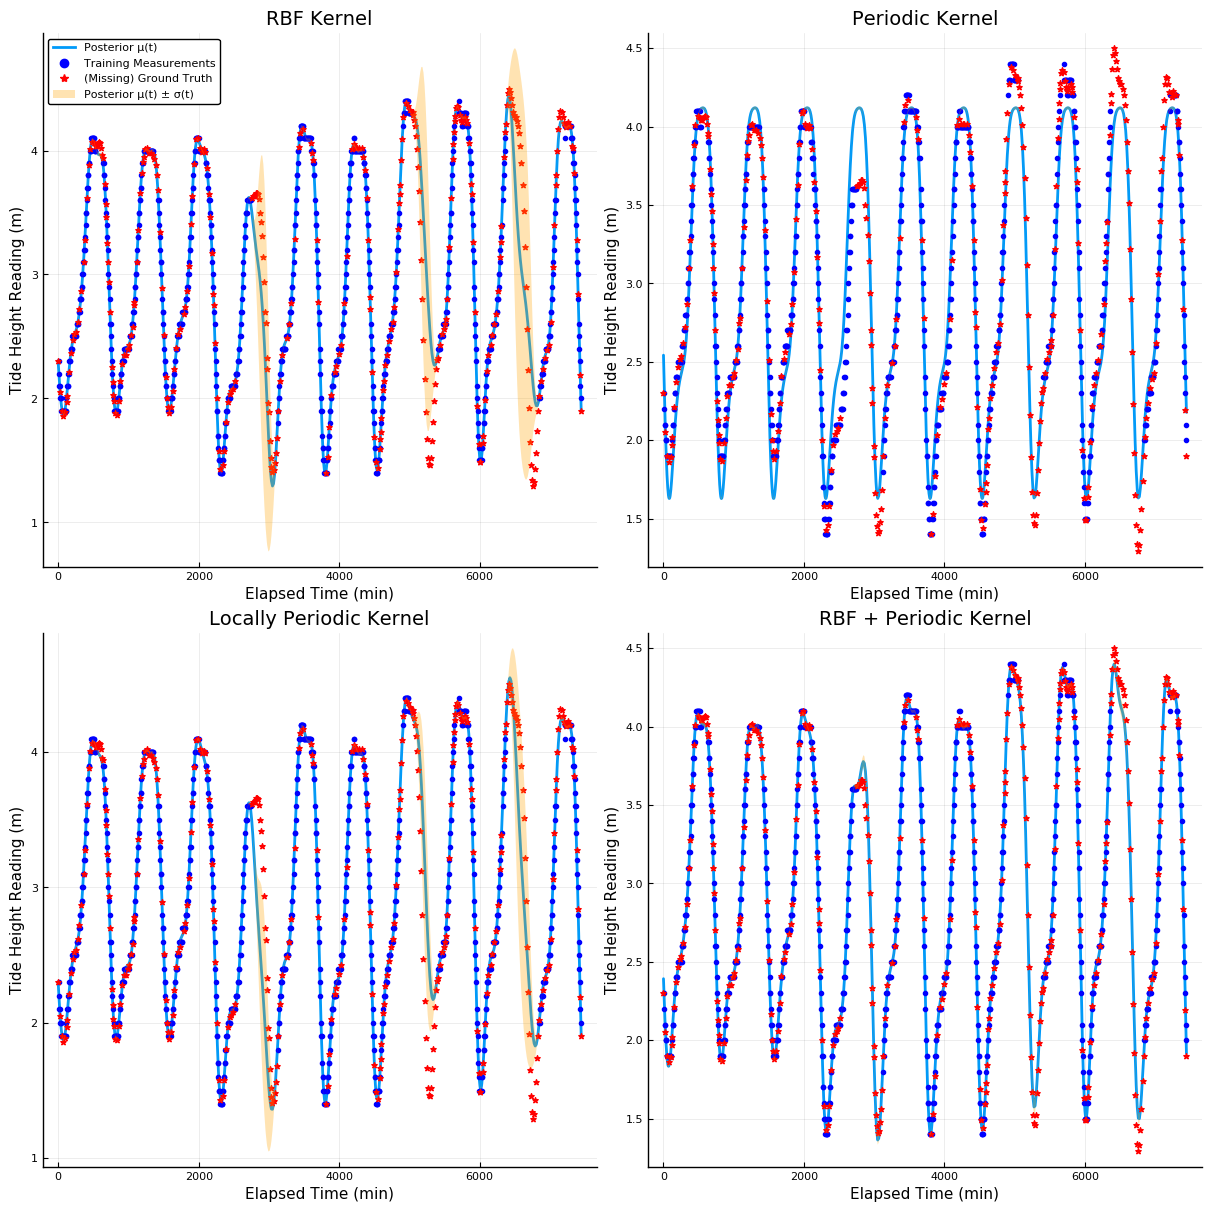

RMS: 0.041
Held Out RMS: 0.068
Predictive Average Log Likelihood: 1.801

In [192]:
println("RBF")
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_sqexp_cov_func(4.55, 1.35), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;
σs = σs .* (y_scale);

p1 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="Posterior μ(t)", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="Training Measurements", title="RBF Kernel")
scatter!(t_pred, y_pred .* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="(Missing) Ground Truth")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="Posterior μ(t) ± σ(t)");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");

println("Periodic")
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_periodic_kernel(0.21, 1.23e-1, 6.61), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;
σs = σs .* (y_scale);

p2 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="", title="Periodic Kernel")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");


println("Locally Periodic")
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_local_periodic_kernel(0.097, 5.52, 9.5, 4.68), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;
σs = σs .* (y_scale);

p3 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="", title="Locally Periodic Kernel")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");

println("Periodic + RBF")
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, gen_local_sum_periodic_kernel(0.148, 0.06,  6.61, -1.48, 4.53), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
means = means .* y_scale .+ y_offset;
σs = σs .* (y_scale);

p4 = plot(t, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", show=true, size=(800, 800), linewidth=2, legend=:topleft)
plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, markershape=:circle,  markerstrokecolor=:blue, markercolor=:blue, markersize=3, label="", title="RBF + Periodic Kernel")
scatter!(t_pred, y_pred.* y_scale .+ y_offset, seriestype=:scatter, markershape=:star, markerstrokecolor=:red, markercolor=:red, label="")
# plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, linewidth=0, show=true, label=["Posterior Mean + 1 std", "Posterior Mean - 1 std"])
plot!(t, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
plot!(t, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");

plot(p1, p2, p3, p4, layout=(2, 2), size=(1200, 1200))
savefig("main_summary.pdf")

In [167]:
κ′ = gen_local_sum_periodic_kernel(0.148, 0.06,  6.61, -1.48, 4.53);

## Sequential Predictons

In [194]:
σₙ = 0.1;

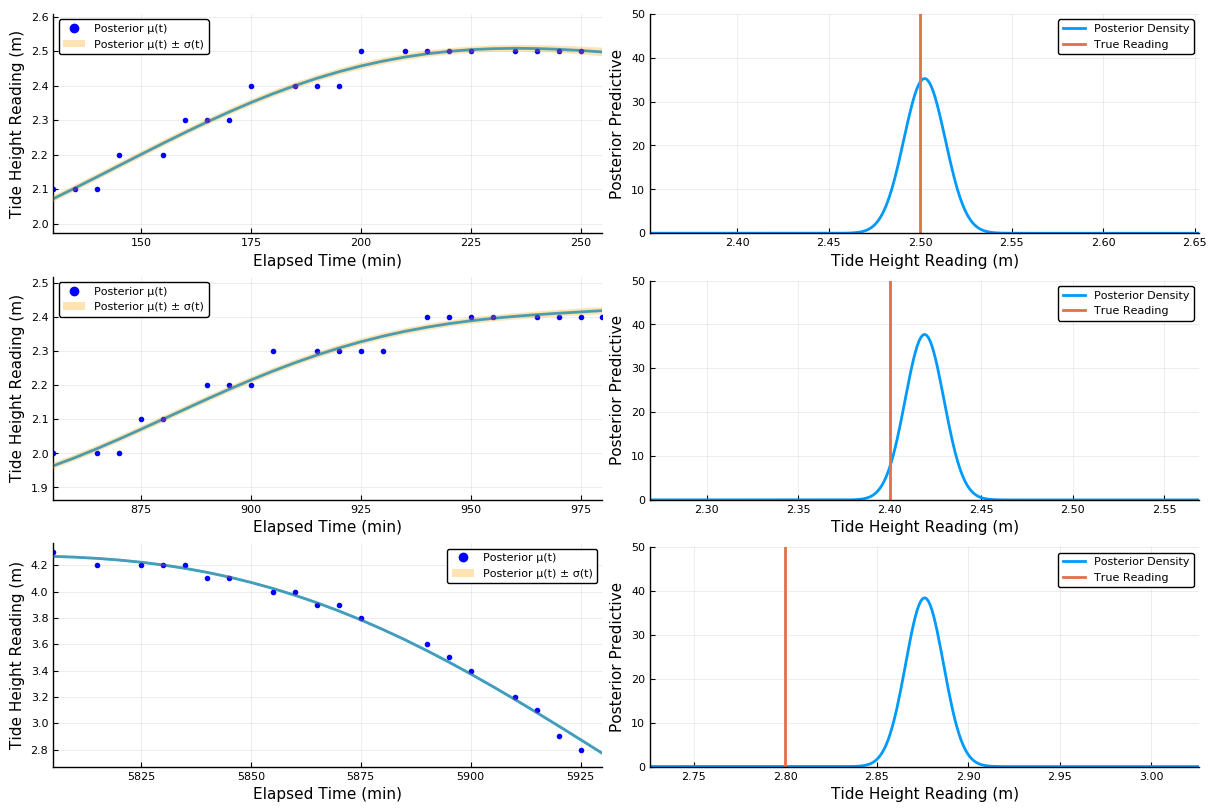

In [197]:
t = (map(Dates.datetime2unix, data[:, 3]) .- Dates.datetime2unix(data[1, 3]))/60
y_offset = Statistics.mean(skipmissing(data[:, 6]))
y_scale = Statistics.std(skipmissing(data[:, 6]))

y = (data[:, 6] .- y_offset) ./ y_scale
missing_indices = map(ismissing, y);

ground_truth = (data[:, 11] .- y_offset) ./y_scale;
t_all = reshape(t, length(t), 1)

t_train = reshape(t[map(~, missing_indices)] , length(t[map(~, missing_indices)]),  1)
y_train = Array{Float64}(y[map(~, missing_indices)])

T_pred_index = [53, 186, 1035];
plots = []

for t in T_pred_index
    t_pred = t_all[t]
    
    prev_train = reshape(t_train[t_train.<t_pred], length(t_train[t_train.<t_pred]), 1)
    prev_y = y_train[findall(t_train.<t_pred)]
    prev_pred = reshape(t_all[t_all.<t_pred], length(t_all[t_all.<t_pred]), 1)

    means, σs, full_cov, func_cov = compute_predictive_distribution(prev_pred, prev_train, prev_y, κ′, σₙ);
    means = means .* y_scale .+ y_offset;
    σs = σs .* (y_scale);
    p = plot(prev_pred, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", xlim=(prev_pred[end-25], prev_pred[end]),
        ylim=(minimum(means[end-25:end])-0.1, maximum(means[end-25:end])+0.1), linewidth=2);
    plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, label="Posterior μ(t)", markershape=:circle, markerstrokecolor=:blue, markercolor=:blue, markersize=3)
    plot!(prev_pred, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="Posterior μ(t) ± σ(t)");
    plot!(prev_pred, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
    push!(plots,p);
    
    final_value = prev_train[end]
    final_reading = prev_y[end] * y_scale + y_offset 
    indx = 1:length(prev_pred)
    indx = indx[findall(prev_pred .== final_value)]
    final_mean = means[indx][1]
    final_σ = σs[indx][1]
    dist = Distributions.Normal(final_mean[1], final_σ[1])
    xvals = Array(final_mean-0.5:0.001:final_mean+0.15)
    pdf_vals = Distributions.pdf.(dist, xvals)
    p = plot(xvals, pdf_vals, xlabel="Tide Height Reading (m)", ylabel="Posterior Predictive", label="Posterior Density", xlim=(final_mean-0.15, final_mean+0.15), ylim=(0, 50), linewidth=2);
    plot!([final_reading, final_reading], [-2, 55], linewidth=2, label="True Reading")
    push!(plots,p);
end

plot(plots[1], plots[2], plots[3], plots[4], plots[5], plots[6], layout=(3, 2), size=(1200, 800))
savefig("badcal.pdf")

Maybe this means that the model uncertainty/ model noise is too small? Let's try a larger value. Note that in 3 standard deviation of a Gaussian, almost all of the data should lie in that bound. So let's plot $\pm 3\sigma$ for the graph to test calibration, as this should cover all points!

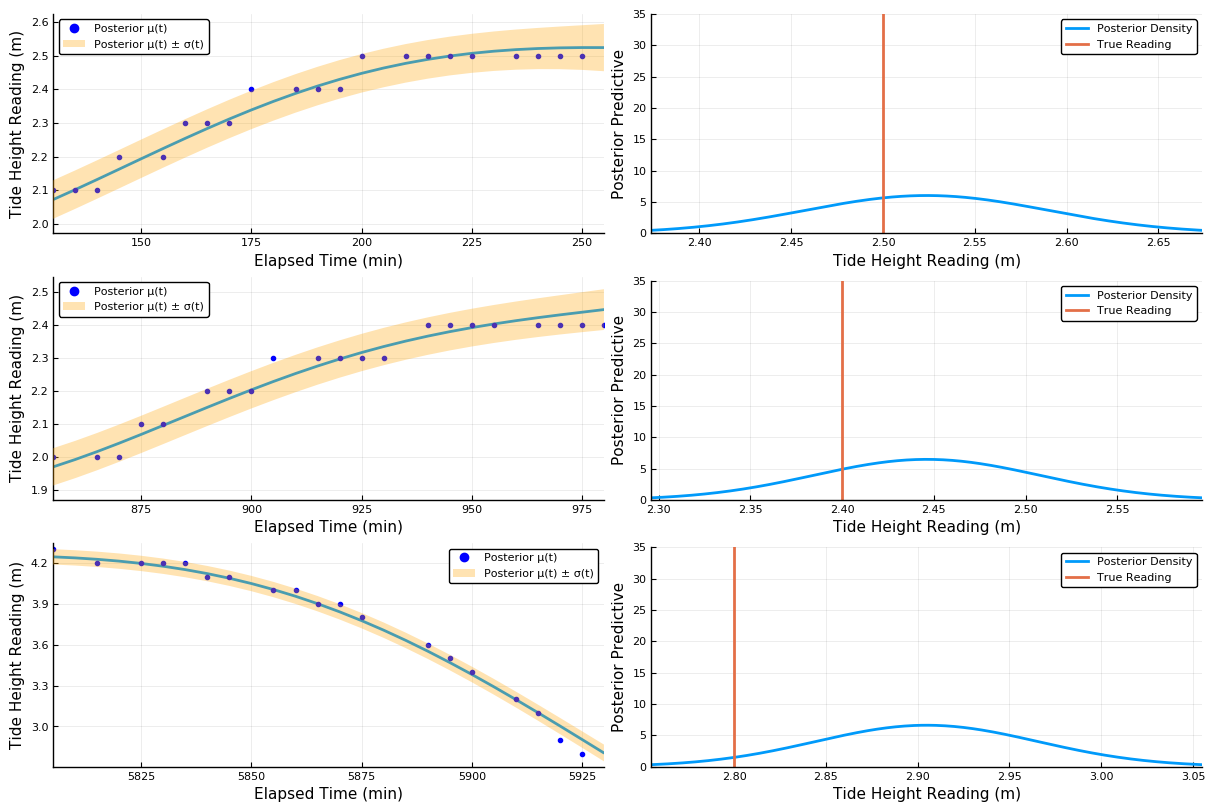

In [198]:
σₙ = 0.25;
t = (map(Dates.datetime2unix, data[:, 3]) .- Dates.datetime2unix(data[1, 3]))/60
y_offset = Statistics.mean(skipmissing(data[:, 6]))
y_scale = Statistics.std(skipmissing(data[:, 6]))

y = (data[:, 6] .- y_offset) ./ y_scale
missing_indices = map(ismissing, y);

ground_truth = (data[:, 11] .- y_offset) ./y_scale;
t_all = reshape(t, length(t), 1)

t_train = reshape(t[map(~, missing_indices)] , length(t[map(~, missing_indices)]),  1)
y_train = Array{Float64}(y[map(~, missing_indices)])

T_pred_index = [53, 186, 1035];
plots = []

for t in T_pred_index
    t_pred = t_all[t]
    
    prev_train = reshape(t_train[t_train.<t_pred], length(t_train[t_train.<t_pred]), 1)
    prev_y = y_train[findall(t_train.<t_pred)]
    prev_pred = reshape(t_all[t_all.<t_pred], length(t_all[t_all.<t_pred]), 1)

    means, σs, full_cov, func_cov = compute_predictive_distribution(prev_pred, prev_train, prev_y, κ′, σₙ);
    means = means .* y_scale .+ y_offset;
    σs = σs .* (y_scale);
    p = plot(prev_pred, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="", xlim=(prev_pred[end-25], prev_pred[end]),
        ylim=(minimum(means[end-25:end])-0.1, maximum(means[end-25:end])+0.1), linewidth=2);
    plot!(t_train, y_train .* y_scale .+ y_offset, seriestype=:scatter, label="Posterior μ(t)", markershape=:circle, markerstrokecolor=:blue, markercolor=:blue, markersize=3)
    plot!(prev_pred, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="Posterior μ(t) ± σ(t)");
    plot!(prev_pred, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, show=true, label="");
    push!(plots,p);
    
    final_value = prev_train[end]
    final_reading = prev_y[end] * y_scale + y_offset 
    indx = 1:length(prev_pred)
    indx = indx[findall(prev_pred .== final_value)]
    final_mean = means[indx][1]
    final_σ = σs[indx][1]
    dist = Distributions.Normal(final_mean[1], final_σ[1])
    xvals = Array(final_mean-0.5:0.001:final_mean+0.15)
    pdf_vals = Distributions.pdf.(dist, xvals)
    p = plot(xvals, pdf_vals, xlabel="Tide Height Reading (m)", ylabel="Posterior Predictive", label="Posterior Density", xlim=(final_mean-0.15, final_mean+0.15), ylim=(0, 35), linewidth=2);
    plot!([final_reading, final_reading], [-2, 45], linewidth=2, label="True Reading")
    push!(plots,p);
end

plot(plots[1], plots[2], plots[3], plots[4], plots[5], plots[6], layout=(3, 2), size=(1200, 800))
savefig("goodcal.pdf")

This looks pretty good to me, so let's go for this!

# Lookahead

Let's try and make some sort of cool lookahead animation plot. 

In [93]:
import PyPlot
pyplot();

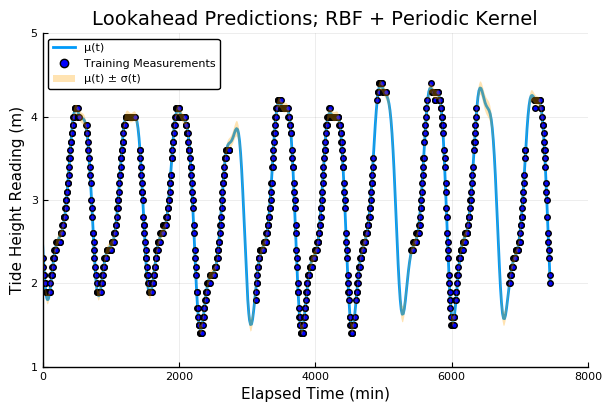

┌ Info: Saved animation to 
│   fn = /Users/mrinank/workspace/AIMS-CDT/estimation_inference/tmp.gif
└ @ Plots /Users/mrinank/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/Users/mrinank/workspace/AIMS-CDT/estimation_inference/tmp.gif")

In [208]:
y = (data[:, 6] .- y_offset) ./ y_scale
missing_indices = map(ismissing, y);

ground_truth = (data[:, 11] .- y_offset) ./y_scale;
t_all = reshape(t, length(t), 1)

t_train = reshape(t[map(~, missing_indices)] , length(t[map(~, missing_indices)]),  1)
y_train = Array{Float64}(y[map(~, missing_indices)])

T_pred = Array(1:length(t_all));

@gif for t in T_pred
    t_pred = t_all[t]
    
    prev_train = reshape(t_train[t_train.<t_pred], length(t_train[t_train.<t_pred]), 1)
    prev_y = y_train[findall(t_train.<t_pred)]
    all_pred = reshape(t_all, length(t_all), 1)
    
    if length(prev_train) > 0
        means, σs, full_cov, func_cov = compute_predictive_distribution(all_pred, prev_train, prev_y, κ′, σₙ);
        means = means .* y_scale .+ y_offset;
        σs = σs .* (y_scale);
        p = plot(all_pred, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="μ(t)", xlim=(0, 8000),
            ylim=(1.0, 5.0), title="Lookahead Predictions; RBF + Periodic Kernel", linewidth=2);
        plot!(prev_train, (prev_y .* y_scale).+ y_offset, seriestype=:scatter, markershape=:circle, markercolor=:blue, label="Training Measurements")
        plot!(all_pred, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, label="μ(t) ± σ(t)");
        plot!(all_pred, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, label="");
#         plot!(all_pred, [means, means], fillrange=[means.-(1 .* σs), means.+(1 .* σs)], fillalpha=0.3, c=:orange, linewidth=0, label="")
    else
        means, σs, full_cov, func_cov = compute_predictive_distribution(all_pred, prev_train, prev_y, κ′, σₙ);
        means = means .* y_scale .+ y_offset;
        σs = σs .* (y_scale);
        p = plot(all_pred, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="μ(t)", xlim=(0, 8000),
            ylim=(1.0, 5.0), title="Lookahead Predictions; RBF + Periodic Kernel", linewidth=2);
        plot!(all_pred, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, label="μ(t) ± σ(t)");
        plot!(all_pred, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, label="");
    end
end

This looks like bad uncertainty calibration to me.  Let's go back to what appeared to be an originally worse kernel. 

In [95]:
Optim.optimize(Periodic_local_likelihood, [0.1, 3.41, 5.35, 4.68], LBFGS())

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.73e-02, 5.52e+00, 9.50e+00,  ...]
    Minimum:   -2.692899e+03

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [1.00e-01, 3.41e+00, 5.35e+00,  ...]

 * Convergence measures
    |x - x'|               = 9.22e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.80e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.72e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.24e-13 ≰ 0.0e+00
    |g(x)|                 = 7.96e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   144  (vs limit Inf)
    Iterations:    27
    f(x) calls:    85
    ∇f(x) calls:   85


In [96]:
ans.minimizer

4-element Array{Float64,1}:
 0.09725720954452917
 5.517885841951565  
 9.498452521644339  
 4.683877849442021  

In [ ]:
Optim.optimize(Periodic_local_likelihood, [0.097, 5.52, 9.5, 4.68], LBFGS())

In [ ]:
ans

Okay fine, it looks like this is the best.

In [ ]:
means, σs, full_cov, func_cov = compute_predictive_distribution(t_all, t_train, y_train, 
    _kernel(0.097, 5.52, 9.5, 4.68), σₙ);
performance_evaluation(ground_truth, means, func_cov, missing_indices);
plot(t, means, xlabel="Elapsed Time (m)", ylabel="Tide Height Reading (m)", label="", show=true, size=(1200, 800))
plot!(t_train, y_train, seriestype=:scatter, label="", markershape=:x)
scatter!(t_pred, y_pred, seriestype=:scatter, label="", markershape=:+, markerstrokecolor=markercolor=:red)
plot!(t, [means, means], fillrange=[means.-σs, means.+σs], fillalpha=0.3, c=:orange, label="", linewidth=0, show=true);

Granted, the MSE is worse, especially on the hend out data, note that the uncertainty seems to be *better* calibitrated that the other model. Let's try lookahead predictions with this model. 

In [211]:
kappa_alt = gen_local_periodic_kernel(0.097, 5.52, 9.5, 4.68);

In [ ]:
y = (data[:, 6] .- y_offset) ./ y_scale
missing_indices = map(ismissing, y);

ground_truth = (data[:, 11] .- y_offset) ./y_scale;
t_all = reshape(t, length(t), 1)

t_train = reshape(t[map(~, missing_indices)] , length(t[map(~, missing_indices)]),  1)
y_train = Array{Float64}(y[map(~, missing_indices)])

T_pred = Array(1:length(t_all));

@gif for t in T_pred
    t_pred = t_all[t]
    
    prev_train = reshape(t_train[t_train.<t_pred], length(t_train[t_train.<t_pred]), 1)
    prev_y = y_train[findall(t_train.<t_pred)]
    all_pred = reshape(t_all, length(t_all), 1)
    
    if length(prev_train) > 0
        means, σs, full_cov, func_cov = compute_predictive_distribution(all_pred, prev_train, prev_y, kappa_alt, σₙ);
        means = means .* y_scale .+ y_offset;
        σs = σs .* (y_scale);
        p = plot(all_pred, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="μ(t)", xlim=(0, 8000),
            ylim=(1.0, 5.0), title="Lookahead Predictions; Locally Periodic Kernel", linewidth=2);
        plot!(prev_train, (prev_y .* y_scale).+ y_offset, seriestype=:scatter, markershape=:circle, markercolor=:blue, label="Training Measurements")
        plot!(all_pred, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, label="μ(t) ± σ(t)");
        plot!(all_pred, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, label="");
#         plot!(all_pred, [means, means], fillrange=[means.-(1 .* σs), means.+(1 .* σs)], fillalpha=0.3, c=:orange, linewidth=0, label="")
    else
        means, σs, full_cov, func_cov = compute_predictive_distribution(all_pred, prev_train, prev_y, κ′, σₙ);
        means = means .* y_scale .+ y_offset;
        σs = σs .* (y_scale);
        p = plot(all_pred, means, xlabel="Elapsed Time (min)", ylabel="Tide Height Reading (m)", label="μ(t)", xlim=(0, 8000),
            ylim=(1.0, 5.0), title="Lookahead Predictions; RBF + Periodic Kernel", linewidth=2);
        plot!(all_pred, means, fillrange=means.-σs, fillalpha=0.3, c=:orange, linewidth=0, label="μ(t) ± σ(t)");
        plot!(all_pred, means, fillrange=means.+σs, fillalpha=0.3, c=:orange, linewidth=0, label="");
    end
end

In [210]:
σₙ

0.25